In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
## Change these variables to your desired values
img_height = 256
img_width = 256
img_channels = 1
    
path_labels = "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/\
762_Project/Codes/Paper_codes/labels/"  # Where the labels are saved   
path_videos = "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/\
762_Project/Codes/Paper_codes/video data_save" # Where the videos are saved 
model_stable_path = './models/model.h5' # From where to load the CNN before training
model_save_path = './models/model.h5' # Where to save the CNN after training

#n=100000 # if you want to limit to a small subset of the data
n=1000
test_size=0.1
val_size=0.1
batch_size = 16    
epochs=2 # For how many epochs to train


FLAG_DEBUG = False
FLAG_GENERATE_TABLE=True # If false: load a previously generated table
FLAG_TRAIN=True # If false: just load a model, do not retrain
FLAG_TRAIN_IN_PRELOAD=False #if false: train with lazy loading (see details in Training Modes section)

label_names=['Human',
             'Interaction frontal',
             'Interaction lateral', 
             'Interaction vertical',
             'Crowded', 
             'Drink',
             'Curiosity', 
             'Queue',
             'Low visibility', 
             'Nothing']

In [3]:
# Math manipulation
import numpy as np
import pandas as pd

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Image processing
import cv2

# Utilities
import os
import random
import gc
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
import codecs, json 
import re

Using TensorFlow backend.
/opt/anaconda3/envs/keras-CS762-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/keras-CS762-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/keras-CS762-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/en

In [4]:
def generate_pointer_table (list_of_videos, path_labels, plot=True, verbose=False):
    pt_table = []
    for filename in list_of_videos:
        with open(filename) as json_file: file_labels = json.load(json_file)[1:]
        i=1
        name = re.search(str(path_labels + '(.+?).json'), filename).group(1)
        if 'pointer_table' in name: continue
        base_time = int(name) 
        while i<len(file_labels):
            if file_labels[i]!=-1: pt_table.append([base_time, i, file_labels[i]])
            i +=1
    return pt_table

In [5]:
#def preprocess_frame(frame):
#    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) # convert to greyscale
#    frame = cv2.resize (frame, (img_width, img_height), interpolation=cv2.INTER_CUBIC) # rezize
#    return frame

def preprocess_frame(frame):
    if type(frame) != int and len(frame.shape)>1:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) # convert to greyscale
    frame = cv2.resize (frame, (img_width, img_height), interpolation=cv2.INTER_CUBIC) # rezize
    return frame

In [6]:
def frame_from_pointer (path, video, frame, verbose=False):
    if verbose: print ('In '+path+'/'+str(video)+'.mp4' + ', taking frame ' + str(frame))
    cap = cv2.VideoCapture(path+'/'+str(video)+'.mp4')
    if (cap.isOpened()== False):
        print("Error opening video file") 
        return -1
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
    ret, frame = cap.read() # Capture next frame
    if ret==True:
        cap.release()
        return frame
    else:
        print("Error opening frame") 
        return -1

In [7]:
list_of_videos = [path_labels + i for i in sorted(os.listdir(path_labels))]
pointer_table_path = path_labels + 'pointer_table.json'
pointer_table_shuffled_path = path_labels + 'pointer_table_shuffled.json'
if FLAG_DEBUG: print ('Number of files: ', len(list_of_videos))
    
if FLAG_GENERATE_TABLE:   
    pt_table = generate_pointer_table (list_of_videos, path_labels)
    json.dump(pt_table, codecs.open(pointer_table_path, 'w', encoding='utf-8'))
    print ('Pointer table saved')
    random.shuffle(pt_table)
    json.dump(pt_table, codecs.open(pointer_table_shuffled_path, 'w', encoding='utf-8'))
    print ('Shuffled pointer table saved')
    
else:
    with open(pointer_table_shuffled_path) as json_file: pt_table = json.load(json_file)
    #random.shuffle(pt_table)  #if you want to shuffle again
    
pt_table = np.array(pt_table)


train_max_index = int(n*(1-test_size - val_size))
val_max_index = int(train_max_index + n*val_size)
test_max_index = int(val_max_index + n*test_size)

pt_table_train = pt_table[0:train_max_index]
pt_table_val = pt_table[train_max_index:val_max_index]
pt_table_test = pt_table[val_max_index:test_max_index]

if FLAG_DEBUG:
    print ('Train index = ',0,':', train_max_index)
    print ('Val index   = ', train_max_index,':', val_max_index)
    print ('Test index  = ', val_max_index,':', test_max_index)


#del list_of_videos, pt_table
gc.collect()

Pointer table saved
Shuffled pointer table saved


64

# Training modes
To improve the training process, we developed two different modes of training that differ in the way the data is handled during the training: pre-loading the images or loading just-in-time. 

The **pre-loaded mode** loads the images into the computer's temporary memory only at the beginning of the training phase. This allows faster training; nevertheless, it was not possible to load more than 40k images at the same time without available hardware.

The **just-in-time loading** (also designated in the documentation as lazy loading) retrieves the images from disk every time they are required in the training phase. This allows training with the entire dataset, no matter how big it is, but has the drawback that the same image had to be loaded several times (for instance: to train 10 epochs is necessary to load the same image 10 times).

To change the training mode is enough to change the varible FLAG_TRAIN_IN_PRELOAD value. To train the network presented in this work, we used the just-in-time loading mode.

In [8]:
from albumentations import Compose
import albumentations as A
import random

augmentation_train = A.Compose([
    A.RandomContrast(limit=0.3, p=0.5),
    A.RandomGamma(gamma_limit=(70, 130), p=0.5),
    A.RandomBrightness(limit=0.6, p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05, 
        scale_limit=0.05, 
        rotate_limit=10, 
        border_mode=cv2.BORDER_CONSTANT, 
        p=0.5), 
    A.ToFloat(max_value=255),
])

augmentation_test = A.Compose([
    A.ToFloat(max_value=255)
])

In [9]:
## Preload import 
# require more RAM, but train fast
# verbose:   0=quiet, 1=inline output, 2=save figs
def preload_import (pt_table, X_path, verbose=1):
    X = []
    y = []
    for pointer in pt_table:
        #print ('.')
        frame = frame_from_pointer(path=X_path, video=pointer[0], frame=pointer[1])
        frame = preprocess_frame(frame)
        X.append(frame)
        y.append(to_categorical(pointer[2], num_classes=10))

    X = np.array(X)
    y = np.array(y)  
    if verbose>=1:
        print('------------------------')
        print('Some random pics:')
        plt.figure(figsize=(100,100))
        cols = 4
        rows = 4
        for c in range(cols):
            for r in range(rows):
                plt.subplot(rows, cols, c + cols*r + 1)
                plt.imshow(X[c + cols*r])
                plt.title(label_names[np.argmax(y[c + cols*r])], fontsize=102)
                
                plt.axis('off')
        if verbose>1: plt.savefig('sample_randoms.png')
            
    return X,y

In [10]:
if FLAG_TRAIN_IN_PRELOAD:
    X_train, y_train = preload_import (pt_table_train, X_path=path_videos, verbose=1)
    print('Train dataset loaded')
    X_val, y_val = preload_import (pt_table_val, X_path=path_videos, verbose=1)
    print('Val dataset loaded')    
    print('-- Split report (np shapes) --' + 
         '\nTrain X      : ' + str(X_train.shape) + 
         '\nTrain y      : ' + str(y_train.shape) + 
         '\nValidation X : ' + str(X_val.shape) + 
         '\nValidation y : ' + str(y_val.shape))

In [11]:
def image_generator_preloaded (X_train, y_train, batch_size, augmentation): 
    indices = np.arange(len(X_train)) 
    while True:
        batch_indices = np.random.choice(indices, batch_size, replace=False)
        batch_X = []
        batch_y = []
        
        for i in batch_indices:
            frame = X_train[i]
            frame = augmentation(image=frame)['image']
            frame = frame.reshape(frame.shape[0], frame.shape[1], img_channels)
            batch_X.append(frame)
            batch_y.append(y_train[i])
            
        # Return a tuple of (input,output) to feed the network   
        batch_X = np.array(batch_X)
        batch_y = np.array(batch_y)
        yield(batch_X, batch_y)

if FLAG_TRAIN_IN_PRELOAD:
    #get the length of the train and validation data
    ntrain = len(X_train)
    nval = len(X_val)

    train_generator = image_generator_preloaded (X_train, y_train, batch_size=batch_size, augmentation=augmentation_train)
    val_generator = image_generator_preloaded (X_train, y_train, batch_size=batch_size, augmentation=augmentation_test)

In [12]:
def image_generator_lazy (pt_table, batch_size, augmentation):
    while True:          # Select files (paths/indices) for the batch
        pointer_batch = pt_table[np.random.choice(pt_table.shape[0], batch_size, replace=False), :]
        batch_X = []
        batch_y = []
        
        for pointer in pointer_batch:
            frame = frame_from_pointer(path=path_videos, video=pointer[0], frame=pointer[1])
            #print(type(frame))
            #if type(frame) != int: print(frame.shape)
            frame = preprocess_frame(frame)
            frame = frame.astype(np.float32) # MT added 
            frame = augmentation(image=frame)['image']
            frame = frame.reshape(frame.shape[0], frame.shape[1], img_channels)
            label = to_categorical(pointer[2], num_classes=10)
        
            batch_X.append(frame)
            batch_y.append(label)
             
        # Return a tuple of (input,output) to feed the network          
        batch_X = np.array(batch_X)
        batch_y = np.array(batch_y)
        yield(batch_X, batch_y)

if not FLAG_TRAIN_IN_PRELOAD:
    #get the length of the train and validation data
    ntrain = len(pt_table_train)
    nval = len(pt_table_val)

    train_generator = image_generator_lazy (pt_table_train, batch_size=batch_size, augmentation=augmentation_train)
    val_generator = image_generator_lazy (pt_table_val, batch_size=batch_size, augmentation=augmentation_test)

In [13]:
# Visualizing one batch
if FLAG_DEBUG:
    batch_X, batch_y = next(train_generator)
    print(batch_X.shape)
    print(batch_y.shape)

    plt.figure(figsize=(100,100))
    cols = 4
    rows = 4
    for c in range(cols):
        for r in range(rows):
            plt.subplot(rows, cols, c + cols*r + 1)
            img = batch_X[c + cols*r].reshape(batch_X[c + cols*r].shape[0], batch_X[c + cols*r].shape[1])
            print ('Frame stats: ', img.mean(), ' - ', img.std())
            plt.imshow(img)
            plt.title(label_names[np.argmax(batch_y[c + cols*r])], fontsize=102)
            plt.axis('off')

# Model definition and training
* That architecture is based on VGGnet architecture, with a few modifications (like dropout)

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#utils
from keras_tqdm import TQDMNotebookCallback

# Models
from keras import applications
from keras.optimizers import SGD, Adam

In [15]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, img_channels)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy']) 
    
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
____________________

In [16]:
#model = load_model(model_stable_path) # load last stable model (can be commented to train from scrach)
initial_epoch=0 # MT added
    
if FLAG_TRAIN: 
    callback_es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
    callback_cp = ModelCheckpoint(model_save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=ntrain // batch_size,
                                  epochs=initial_epoch+epochs,
                                  initial_epoch=initial_epoch,
                                  validation_data=val_generator,
                                  validation_steps=nval // batch_size,
                                  verbose=0, 
                                  callbacks=[TQDMNotebookCallback(), callback_es, callback_cp])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/50 [00:00<?, ?it/s]

OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573927140.mp4"
OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:1@29.736] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


[ERROR:0@29.736] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video fileError opening video file



OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@30.384] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570352340.mp4"
[ERROR:1@31.224] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:0@31.300] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file


2022-10-26 15:16:50.254811: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573070400.mp4"
[ERROR:0@37.493] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@38.965] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573556400.mp4"
[ERROR:1@39.532] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574107200.mp4"
[ERROR:1@39.545] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573070400.mp4"
[ERROR:0@39.924] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:0@40.937] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573927140.mp4"
[ERROR:0@40.943] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573038000.mp4"
[ERROR:0@41.373] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:0@41.376] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@41.858] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@42.241] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:0@45.461] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573556400.mp4"
[ERROR:1@46.114] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572170400.mp4"
[ERROR:0@46.293] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573927140.mp4"
[ERROR:0@49.087] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@50.466] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573070400.mp4"
[ERROR:0@51.561] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572170400.mp4"
[ERROR:0@51.563] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574107200.mp4"
[ERROR:1@56.497] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:0@58.608] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:0@59.421] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573225200.mp4"
[ERROR:0@59.422] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:0@59.739] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573070400.mp4"
[ERROR:0@60.007] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573038000.mp4"
[ERROR:0@60.900] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@66.682] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571129940.mp4"
[ERROR:1@67.341] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573722000.mp4"
[ERROR:1@68.348] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:0@69.905] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573927140.mp4"
[ERROR:0@71.082] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:0@71.434] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573556400.mp4"
[ERROR:1@71.851] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:0@72.855] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:1@73.061] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@74.075] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573038000.mp4"
[ERROR:0@75.961] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@75.993] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@77.400] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:0@79.801] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@81.521] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570352340.mp4"
[ERROR:1@85.249] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@85.251] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/m

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@86.136] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@98.784] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@99.957] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:1@100.357] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@102.112] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@103.124] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573552800.mp4"
[ERROR:1@103.917] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@103.922] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@108.269] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:1@109.195] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@111.015] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@117.217] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@122.137] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570352340.mp4"
[ERROR:1@126.503] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@127.997] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@127.999] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@130.521] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@131.118] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@131.602] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:1@142.112] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@143.555] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:1@147.190] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573552800.mp4"
[ERROR:1@150.509] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@157.968] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570352340.mp4"
[ERROR:1@157.970] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572274740.mp4"
[ERROR:1@158.779] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@162.487] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:1@168.152] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573070400.mp4"
[ERROR:1@168.454] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573722000.mp4"
[ERROR:1@170.197] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572685140.mp4"
[ERROR:1@170.198] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573225200.mp4"
[ERROR:1@171.509] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570352340.mp4"
[ERROR:1@172.415] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571129940.mp4"
[ERROR:1@176.391] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@178.186] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@180.525] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571129940.mp4"
[ERROR:1@181.098] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@181.700] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@182.193] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571129940.mp4"
[ERROR:1@187.793] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@190.262] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@191.762] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573556400.mp4"
[ERROR:1@193.197] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@193.199] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:1@193.510] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@197.851] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@201.661] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@203.106] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@204.361] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@206.526] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@210.160] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@214.586] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572685140.mp4"
[ERROR:1@215.665] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@220.706] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@221.981] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@223.633] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574107200.mp4"
[ERROR:1@223.702] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@231.913] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574107200.mp4"
[ERROR:1@231.918] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to ./models/model.h5


Epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:0@234.409] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:0@235.472] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573927140.mp4"
[ERROR:0@237.599] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:0@238.574] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573225200.mp4"
[ERROR:0@238.757] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@243.439] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@244.177] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573038000.mp4"
[ERROR:0@245.426] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573038000.mp4"
[ERROR:0@245.432] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@245.959] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:0@247.454] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@248.348] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@250.001] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@253.030] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573225200.mp4"
[ERROR:0@253.193] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574244000.mp4"
[ERROR:1@253.633] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:0@253.775] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@255.936] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@255.941] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:0@257.060] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:0@259.315] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573243320.mp4"
[ERROR:1@260.372] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574107200.mp4"
[ERROR:1@262.012] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@265.005] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@269.410] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573556400.mp4"
[ERROR:1@271.292] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@271.543] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573243320.mp4"
[ERROR:1@272.383] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@274.458] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573552800.mp4"
[ERROR:1@276.461] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573556400.mp4"
[ERROR:1@276.466] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@277.480] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@281.176] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@281.178] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573225200.mp4"
[ERROR:1@281.544] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@282.494] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@286.642] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@286.982] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@289.859] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@293.301] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574107200.mp4"
[ERROR:1@295.753] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@295.756] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@299.771] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573243320.mp4"
[ERROR:1@300.385] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:1@302.654] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@303.582] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572685140.mp4"
[ERROR:1@304.044] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@307.180] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572170400.mp4"
[ERROR:1@308.132] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@312.604] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572685140.mp4"
[ERROR:1@315.478] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@315.963] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@316.370] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@317.539] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@321.149] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@333.167] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@333.555] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570352340.mp4"
[ERROR:1@333.557] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@334.104] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571421540.mp4"
[ERROR:1@334.364] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@336.041] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@338.460] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@338.464] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574244000.mp4"
[ERROR:1@339.103] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@341.695] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574107200.mp4"
[ERROR:1@350.163] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571129940.mp4"
[ERROR:1@351.729] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572685140.mp4"
[ERROR:1@352.411] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@352.618] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@353.021] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573927140.mp4"
[ERROR:1@356.895] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:1@364.535] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@369.890] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@372.152] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573552800.mp4"
[ERROR:1@373.862] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@374.815] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573225200.mp4"
[ERROR:1@376.313] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570211940.mp4"
[ERROR:1@379.623] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572361200.mp4"
[ERROR:1@382.924] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571129940.mp4"
[ERROR:1@384.618] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570352340.mp4"
[ERROR:1@388.183] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573581600.mp4"
[ERROR:1@390.040] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572872400.mp4"
[ERROR:1@390.460] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573225200.mp4"
[ERROR:1@394.291] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574247600.mp4"
[ERROR:1@396.189] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@397.048] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573894980.mp4"
[ERROR:1@397.701] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573556400.mp4"
[ERROR:1@403.719] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572379500.mp4"
[ERROR:1@407.375] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1574107200.mp4"
[ERROR:1@408.845] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572685140.mp4"
[ERROR:1@411.390] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572685140.mp4"
[ERROR:1@412.125] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@414.695] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573912800.mp4"
[ERROR:1@414.984] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573070400.mp4"
[ERROR:1@418.377] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573070400.mp4"
[ERROR:1@422.125] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1570186800.mp4"
[ERROR:1@422.127] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572685140.mp4"
[ERROR:1@422.797] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572170400.mp4"
[ERROR:1@424.280] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573038000.mp4"
[ERROR:0@426.963] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@427.029] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work

Error opening video file
Error opening video file

Epoch 00002: val_acc did not improve from 0.00000


Error opening video file


OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1572199200.mp4"
[ERROR:0@427.867] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




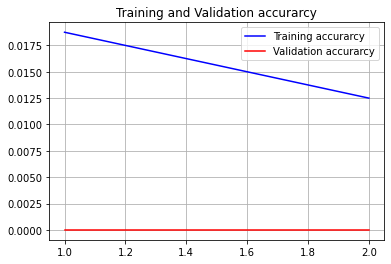

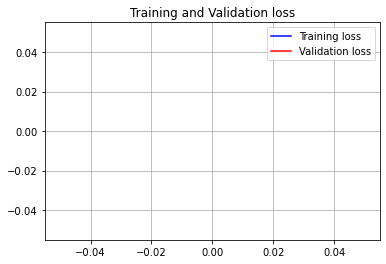

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation acc
plt.grid(True)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.grid(True)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# Test

In [18]:
if FLAG_TRAIN:
    model = load_model(model_save_path) # load the best model saved in training phase

OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1573225200.mp4"
[ERROR:0@428.585] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


AttributeError: 'str' object has no attribute 'decode'

In [ ]:
# The test should be done with pre loading, so I will take directly from the generator 
test_generator = image_generator_lazy (pt_table_test, batch_size=batch_size, augmentation=augmentation_test)

X_test = []
y_test = []
predictions = []
for i in range(0, int(len(pt_table_test)/batch_size)):
    X_batch, y_batch = next(test_generator)
    predictions_batch = model.predict_on_batch(X_batch)
    X_test.extend(X_batch)
    y_test.extend(y_batch)
    predictions.extend(predictions_batch)

X_test = np.array (X_test)
y_test = np.array (y_test)
predictions = np.array (predictions)

In [ ]:
_, acc = model.evaluate(X_test, y_test)
print('Test acc:', acc)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
# Brief: evaluate the 'accuracy' as considering a hit if the true label is in one of the three most confident predictions
# Return: acc
def evaluate_minority_acc (y, y_hat):
    acc = 0
    for i in range(0, len(y), 1):
        pred_array = []
        pred_array.append(np.where(y_hat[i] == sorted(y_hat[i])[-1])[0][0])
        pred_array.append(np.where(y_hat[i] == sorted(y_hat[i])[-2])[0][0])
        pred_array.append(np.where(y_hat[i] == sorted(y_hat[i])[-3])[0][0])
        if np.argmax(y[i]) in pred_array: acc += 1
    return acc/len (y)
    
    
evaluate_minority_acc(y_test, predictions)

In [ ]:
# Brief: plot the image with the predicted label, confidence and real label
def plot_image(i, prediction, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.reshape(img.shape[0], img.shape[1]))

    if np.argmax(prediction) == np.argmax(true_label):
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{}) {}, {:2.0f}% \n({})".format(
        i,
        label_names[np.argmax(prediction)],
        100*np.max(prediction),
        label_names[np.argmax(true_label)]), color=color)

# Brief: plot a bar graph with the probability of each predicted class
def plot_value_array(prediction, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    thisplot = plt.bar(range(10), prediction, color="#777777")

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
if FLAG_DEBUG:
    num_rows = 160
    num_cols = 1
    num_images = num_rows*num_cols
    plt.figure(figsize=(7, 4*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], y_test[i], X_test[i])
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(predictions[i],  y_test[i])
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, linewidths=.5)

plot_cm(np.array([np.argmax(xi) for xi in y_test]), np.array([np.argmax(xi) for xi in predictions]))
_n=0
for i in label_names:
    print('Class ' + str(_n) + ': ' + i)
    _n+=1

In [ ]:
import sklearn.metrics as metrics
print(metrics.classification_report(np.array([np.argmax(xi) for xi in y_test]), np.array([np.argmax(xi) for xi in predictions]), target_names=label_names))

OpenCV: Couldn't read video stream from file "/Users/megantabbutt/Desktop/Computer Science Classes/762_AdvancedDeepLearning/762_Project/Codes/Paper_codes/video data_save/1571249040.mp4"
[ERROR:1@429.962] global /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1661642967242/work/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




Error opening video file


License: Creative Commons 4.0 Attribute